In [46]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as plt

In [47]:
data = []
with open('data.txt' , 'r') as f:
    for line in f.readlines():
        data.append(line.strip('\n'))

In [48]:
print(data)

['## Data', 'lsat = Dict{Symbol, Any}(', '  :cumulative Frequency =>', '    [3, 9, 11, 22, 23, 24, 27, 31, 32, 40, 40, 56, 56, 59, 61, 76, 86, 115, 129,', '     210, 213, 241, 256, 336, 352, 408, 429, 602, 613, 674, 702, 1000],', '  :response =>', '    [0 0 0 0 0', '     0 0 0 0 1', '     0 0 0 1 0', '     0 0 0 1 1', '     0 0 1 0 0', '     0 0 1 0 1', '     0 0 1 1 0', '     0 0 1 1 1', '     0 1 0 0 0', '     0 1 0 0 1', '     0 1 0 1 0', '     0 1 0 1 1', '     0 1 1 0 0', '     0 1 1 0 1', '     0 1 1 1 0', '     0 1 1 1 1', '     1 0 0 0 0', '     1 0 0 0 1', '     1 0 0 1 0', '     1 0 0 1 1', '     1 0 1 0 0', '     1 0 1 0 1', '     1 0 1 1 0', '     1 0 1 1 1', '     1 1 0 0 0', '     1 1 0 0 1', '     1 1 0 1 0', '     1 1 0 1 1', '     1 1 1 0 0', '     1 1 1 0 1', '     1 1 1 1 0', '     1 1 1 1 1],', '  :N => 1000', ')', '']


In [49]:
choices = []
print()
for student in data[6 : len(data) - 3]:
    choice = []
    student_rev = student[::-1]
    student_split = student.split(' ')
    for c in student_split[-5 : ]:
        if '[' in c:
            choice.append(int(c[1]))
        elif ']' in c:
            choice.append(int(c[0]))
        else:
            choice.append(int(c))
    choices.append(choice)
        

In [50]:
cumulative = []

cum1 = data[3].strip(' ')
cum2 = data[4].strip(' ')[:-1]
cum1 = cum1.strip('[')
cum2 = cum2.strip(']')
cum = cum1 + cum2
cum_split = cum.split(',')

for c in cum_split:
    cumulative.append(int(c))

cumulative = np.array(cumulative)

Rasch Model

$\Pr(X_{ni}=1) = \frac{e^{\beta_n - \delta_i}}{1 + e^{\beta_n - \delta_i}}$

$\beta_n$ = ability of student n

$\delta_i$ = difficulty of item i

https://towardsdatascience.com/a-bayesian-approach-to-rasch-models-item-response-theory-cc08805cbb37

In [51]:
data_matrix = []

for idx in range(len(cumulative)):
    if idx == 0:
        for i in range(cumulative[idx]):
            data_matrix.append(choices[idx])
    else: 
        for i in range(cumulative[idx] - cumulative[idx - 1]):
            data_matrix.append(choices[idx])

data_matrix  = np.array(data_matrix)

In [52]:
data_matrix

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [53]:
with pm.Model() as model:
    
    # prior on alpha
    alpha = pm.Normal('alpha', mu=0, sigma=100 , shape = (1,5))
    alpha = alpha - alpha.mean(0)

    # prior on beta
    beta = pm.HalfFlat('beta')

    # prior on theta
    theta = pm.Normal('theta' , mu = 0 , sigma = 1 , shape = (1000,1))

    
    p = pm.Deterministic('p' , beta * theta - alpha)


    y = pm.Bernoulli('y' , logit_p = p , observed = data_matrix)

    trace = pm.sample(2500, tune=500, return_inferencedata=True , progressbar=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]


Sampling 4 chains for 500 tune and 2_500 draw iterations (2_000 + 10_000 draws total) took 34 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",0.96,99.29,-182.56,193.02,0.79,1.16,15545.87,6698.47,1.0
"alpha[0, 1]",-1.12,98.84,-191.50,183.89,0.78,1.13,16007.63,6967.02,1.0
"alpha[0, 2]",0.97,98.88,-187.33,183.97,0.78,1.17,15898.91,6683.60,1.0
"alpha[0, 3]",1.13,101.05,-187.89,189.82,0.82,1.24,15141.02,6480.54,1.0
"alpha[0, 4]",0.18,98.82,-185.00,183.58,0.79,1.16,15477.75,6696.99,1.0
beta,1.58,0.07,1.45,1.72,0.00,0.00,2962.58,3440.21,1.0


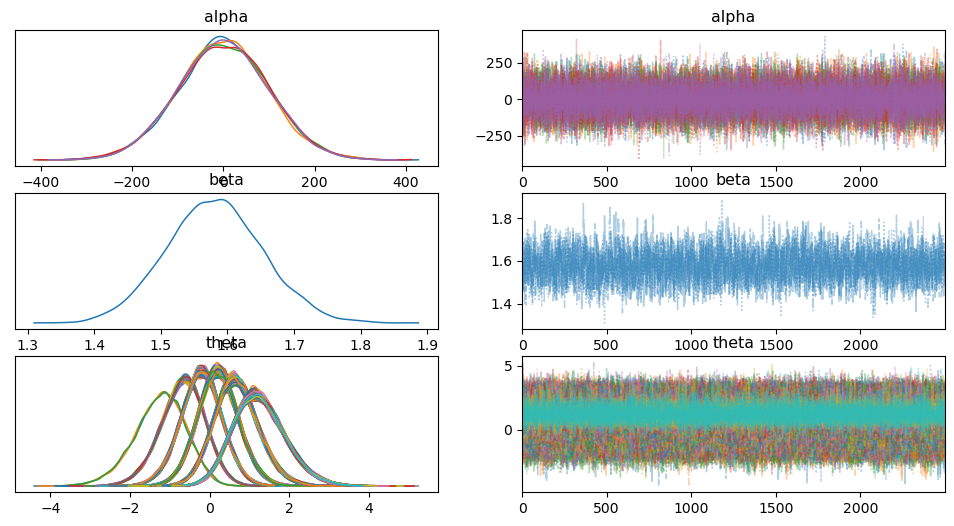

In [54]:
az.plot_trace(trace , var_names = ['alpha' , 'beta' , 'theta'] , combined = True)

with model:
    display(az.summary(trace , var_names = ['alpha' , 'beta'] , round_to = 2))

In [55]:
with pm.Model() as model:
    
    # prior on alpha
    alpha = pm.Normal('alpha', mu=0, sigma=100 , shape = (1,5))
    alpha = alpha - alpha.mean(0)

    # prior on beta
    beta = pm.HalfFlat('beta')

    # prior on theta
    theta = pm.Normal('theta' , mu = 0 , sigma = 1 , shape = (1000,1))

    
    p = pm.Deterministic('p' , beta * theta - alpha)


    y = pm.Bernoulli('y' , logit_p = p , observed = data_matrix)

    mean_field = pm.fit(2500, method='advi')

Finished [100%]: Average Loss = 3,506.9


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/tanmaygoyal/opt/anaconda3/envs/test_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


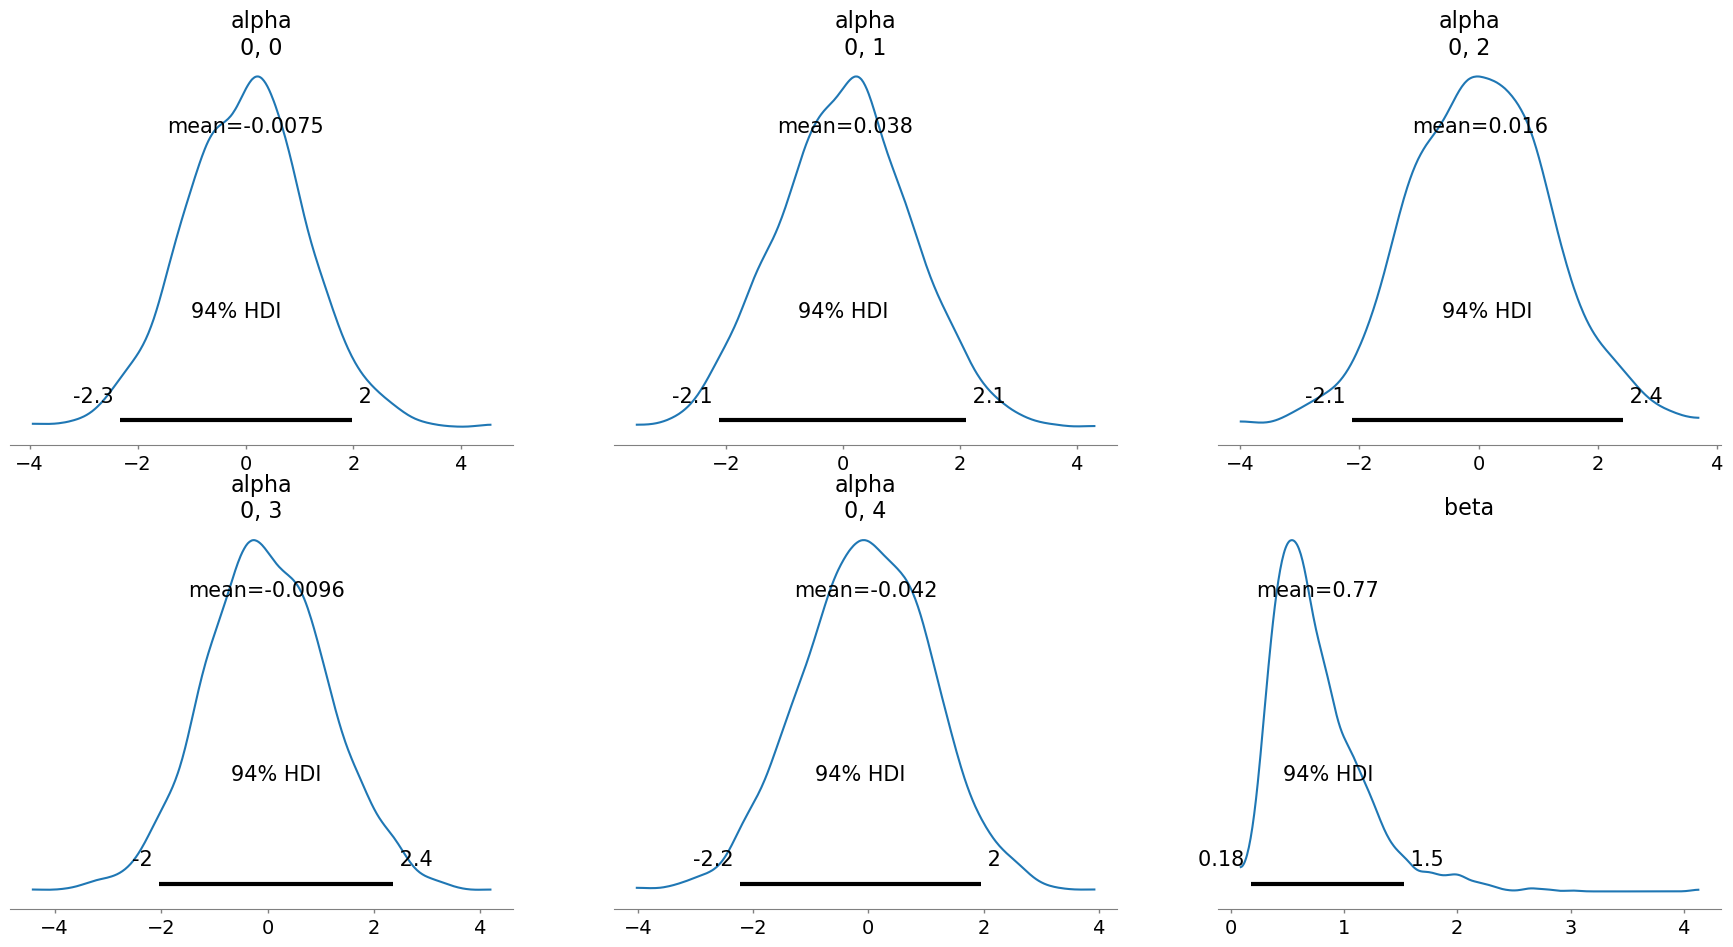

In [59]:
trace = mean_field.sample(2000)
pm.plot_posterior(trace , var_names = ['alpha' , 'beta'])
plt.show()

In [58]:
display(az.summary(trace , var_names = ['alpha' , 'beta'] , round_to = 2))

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"alpha[0, 0]",-0.02,1.16,-2.31,2.01,0.03,0.02,1961.81,1970.60,NaN
"alpha[0, 1]",-0.05,1.17,-2.34,2.04,0.03,0.02,1956.08,1718.26,NaN
"alpha[0, 2]",-0.00,1.15,-2.19,2.07,0.03,0.02,1963.63,1639.36,NaN
"alpha[0, 3]",0.03,1.18,-2.17,2.23,0.03,0.02,2136.55,1890.86,NaN
"alpha[0, 4]",-0.02,1.17,-2.14,2.21,0.03,0.02,1741.65,1958.89,NaN
beta,0.74,0.41,0.17,1.49,0.01,0.01,1848.80,1920.34,NaN
